- git에 커밋 안됨. 원인 파악하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip -qq "/content/drive/MyDrive/incheon/incheon.zip" -d "/content/drive/MyDrive/incheon"

# 필요한 라이브러리 설치

In [ ]:
# 1. 필요한 라이브러리 설치 및 로드
"""  ftfy (Fixes Text for You)
의미: "문자열 깨짐(인코딩 문제)을 자동으로 복구해주는 라이브러리"
"""
!pip install ftfy tqdm seaborn
!pip install git+https://github.com/openai/CLIP.git


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/openai/CLIP.git to c:\users\hnn07\appdata\local\temp\pip-req-build-77wkiuk5
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\hnn07\AppData\Local\Temp\pip-req-build-77wkiuk5'

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 모델 로드 및 라이브러리 임포트

In [24]:
import os
import torch
import clip
from PIL import Image
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트



In [43]:


# 2. 모델 로딩
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 임베딩 생성

In [44]:
from tqdm import tqdm # Colab에서 잘 작동하는 버전

# 3. 이미지 임베딩 생성
image_dir = "../data/images/incheon"  # 이미지 경로
image_features = [] # 임베딩 저장 리스트
labels = [] # 파일명(확장자 제거) 저장 리스트

file_list = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))])

for filename in tqdm(file_list, desc="🔄 이미지 임베딩 생성 중..."):
    try:
        img_path = os.path.join(image_dir, filename)
        img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        with torch.no_grad(): # 추론 단계에서 그래디언트를 계산하지 않도록 설정.
            feat = model.encode_image(img) # 이미지 임베딩 실시
            feat /= feat.norm(dim=-1, keepdim=True) # 임베딩 벡터를 L2 정규화 함. 방향을 비교하기 위해 1로 맞추서 실행.

            image_features.append(feat.cpu().numpy()[0])
            labels.append(os.path.splitext(filename)[0])
    except Exception as e:
        print(f"⚠️ {filename} 오류 발생: {e}")
        

🔄 이미지 임베딩 생성 중...: 100%|██████████| 1444/1444 [00:53<00:00, 26.85it/s]


# t-SNE 시각화
- 실험 결과
  - 뚜렷한 분류 결과를 확인하기에는 어려웠다. 그렇기에 K-meas 알고리즘을 활용해 군집화하고 이를 확인하고자 한다.

c:\Users\hnn07\Documents\Gptrip\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


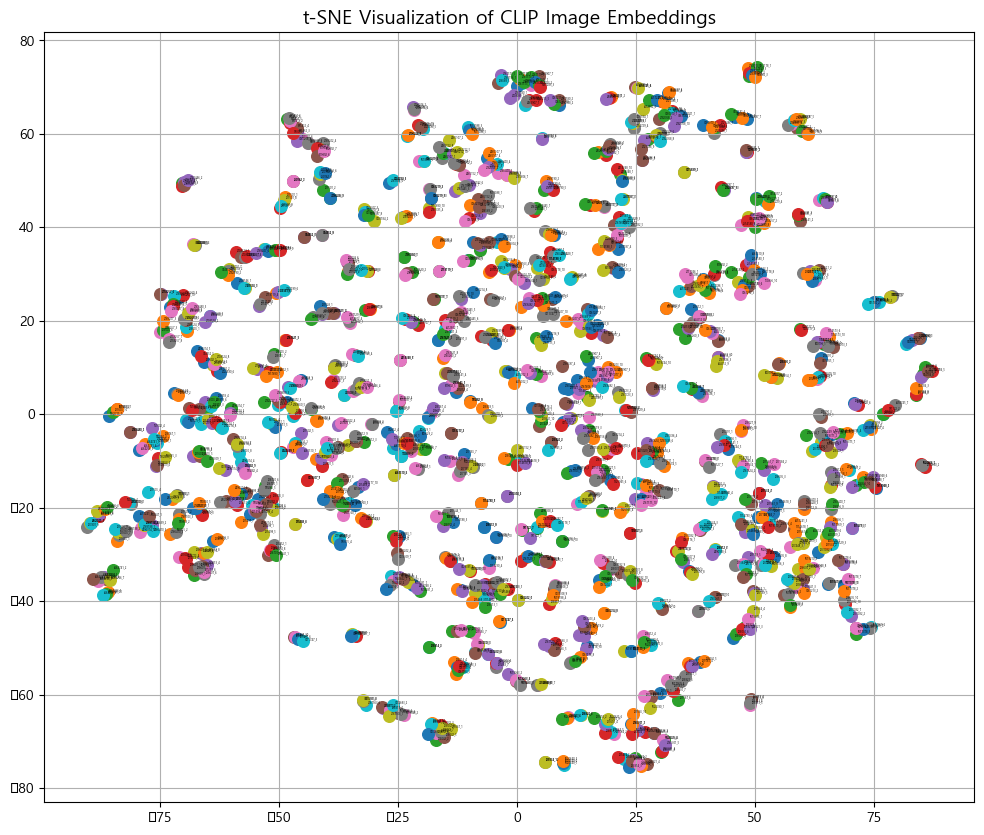

In [45]:
image_features_np = np.vstack(image_features)

# 4. t-SNE 시각화
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_result = tsne.fit_transform(image_features_np)

# 5. 시각화 출력
plt.figure(figsize=(12, 10))
for i, label in enumerate(labels):
    x, y = tsne_result[i]
    plt.scatter(x, y, s=70)
    plt.text(x + 0.3, y + 0.3, label, fontsize=2)
plt.title("t-SNE Visualization of CLIP Image Embeddings", fontsize=14)
plt.grid(True)
plt.show()

## 군집화
- 일단 군집화를 여러 개를 하면서 데이터를 확인해보았다. 군집화를 해보면서 확인한 결과, 어느 정도의 유사성이 있음을 확인하였다. 최적화된 군집화를 찾아야 할 필요성을 느꼈다.
### 대처 방안
- Elbow Method
  - 클러스터 수가 증가할수록 SSE(응집도) 감소 → 급격한 꺾임(엘보우) 지점이 최적
- Silhouette Score
  - 각 샘플이 자기 클러스터에 얼마나 잘 어울리는지(0~1)
     - 높을 수록 좋다.


In [46]:
from sklearn.cluster import KMeans

# 군집 수 설정 (예: 5개의 감성 분위기 그룹)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(image_features_np)
cluster_ids = kmeans.labels_

c:\Users\hnn07\Documents\Gptrip\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


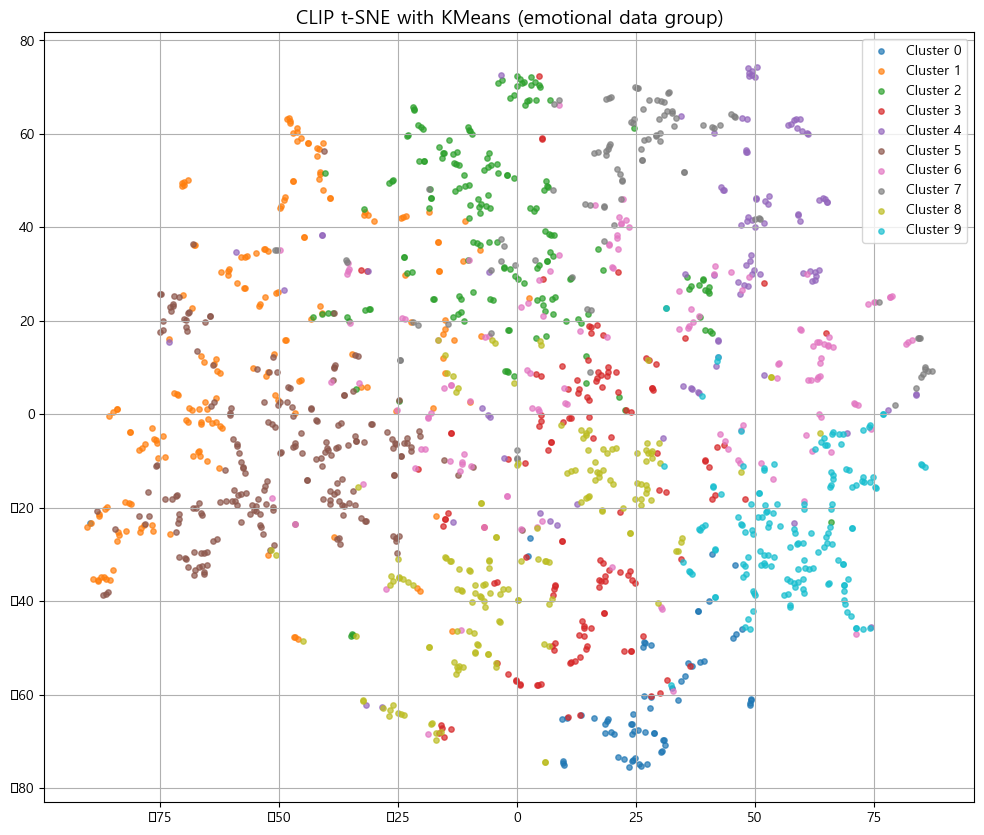

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
palette = sns.color_palette("tab10", n_clusters)

for i in range(n_clusters):
    cluster_points = tsne_result[cluster_ids == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                s=15, color=palette[i], label=f"Cluster {i}", alpha=0.7)

plt.title("CLIP t-SNE with KMeans (emotional data group)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

## 수치 확인 결과
- 확인 결과 6이 적당한 수치를 보임을 확인하였다.
- 해당 데이터를 기반으로 태그 작업을 수행할 때, 수행하기에 좋아 보인다고 판단했다.

- 왼쪽 그래프: Elbow Method (SSE)
  - 급격한 감소가 멈추고 완만해지는 지점이 존재함
    → 이 지점을 **엘보우(elbow)**라고 부르고, 최적의 군집 수 후보로 본다. (확인 결과 약 6~8부터 완만해지기 시작.)
- 오른쪽 그래프: Silhouette Score
  - Y축: Score (0~1) — 군집이 얼마나 잘 분리되었는지를 정량적으로 평가
  - X축: Cluster Count (k)
     - k=6~10 부근에서 비교적 점수의 진폭이 작고 안정적인 부분 존재

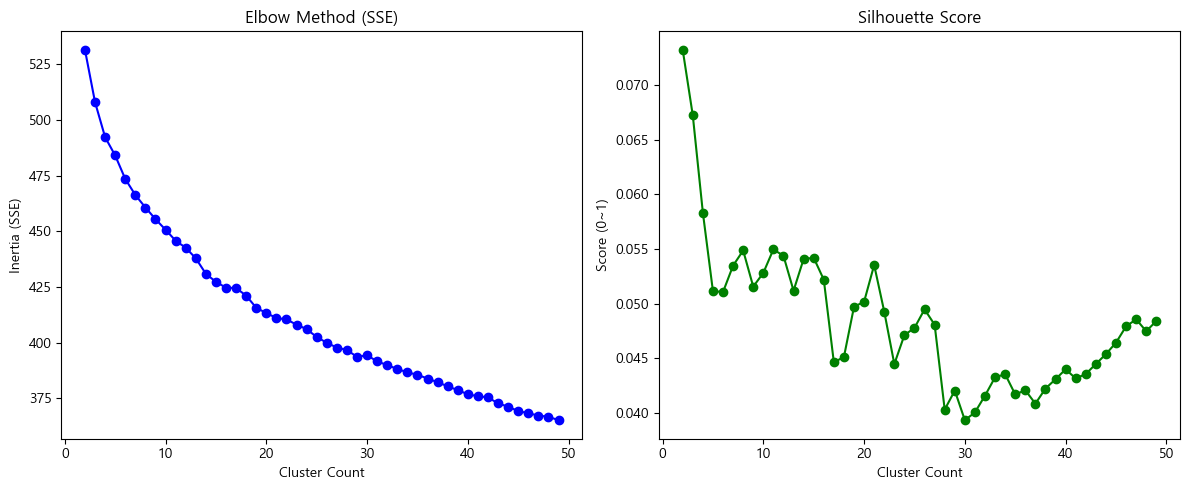

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouettes = []
k_range = range(2, 50)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(image_features_np)
    inertias.append(kmeans.inertia_)
    score = silhouette_score(image_features_np, kmeans.labels_)
    silhouettes.append(score)

# 그래프 출력
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.title("Elbow Method (SSE)")
plt.xlabel("Cluster Count")
plt.ylabel("Inertia (SSE)")

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, 'go-')
plt.title("Silhouette Score")
plt.xlabel("Cluster Count")
plt.ylabel("Score (0~1)")

plt.tight_layout()
plt.show()

In [49]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_ids = kmeans.fit_predict(image_features_np)

C:\Users\hnn07\AppData\Local\Temp\ipykernel_24292\322769285.py:25: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Malgun Gothic.
  plt.tight_layout()


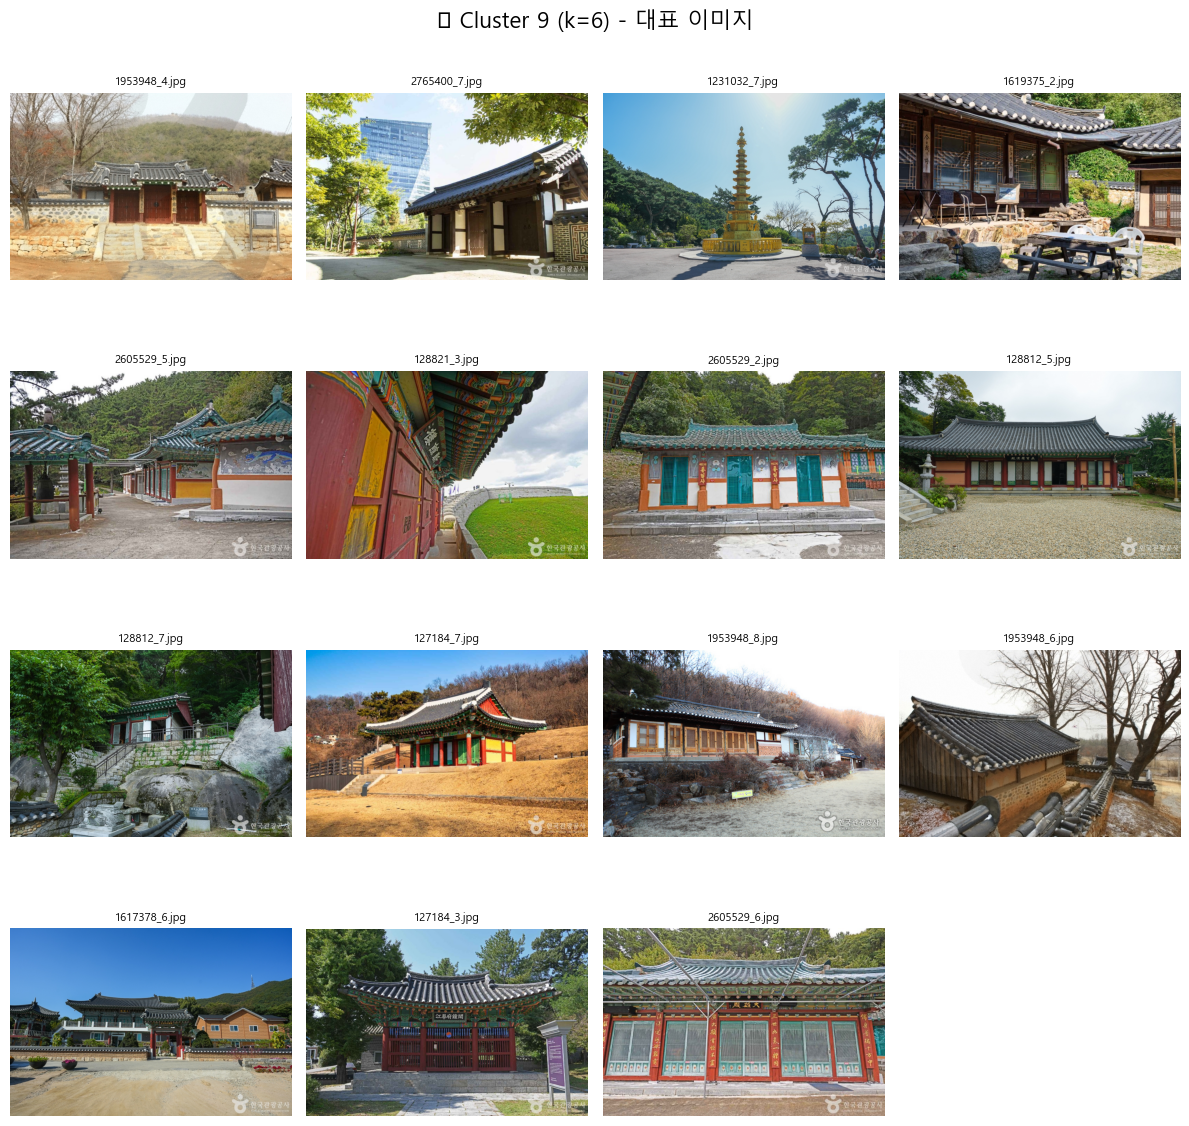

In [53]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

# 👇 예시: Cluster 3 선택
target_cluster = 9
selected_idx = [i for i, cid in enumerate(cluster_ids) if cid == target_cluster]

# 16개만 랜덤 추출
sample_idx = random.sample(selected_idx, min(15, len(selected_idx)))

# 시각화
plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_idx):
    image_path = os.path.join(image_dir, file_list[idx])
    image = Image.open(image_path)

    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"{file_list[idx]}", fontsize=8)

plt.suptitle(f"🟢 Cluster {target_cluster} (k=6) - 대표 이미지", fontsize=16)
plt.tight_layout()
plt.show()

### Pickle로 저장

In [54]:
import pickle

with open("clip_image_embeddings.pkl", "wb") as f:
    pickle.dump({
        "features": image_features_np,
        "filenames": file_list
    }, f)

print("✅ 임베딩 데이터 저장 완료: clip_image_embeddings.pkl")

✅ 임베딩 데이터 저장 완료: clip_image_embeddings.pkl


### 불러올 때

In [5]:
import pickle
with open("incheon_image_embeddings.pkl", "rb") as f:
    data = pickle.load(f)
    image_features_np = data["features"]
    file_list = data["filenames"]